In [5]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Repository-relative paths
ROOT = Path.cwd().parent  # notebooks -> upreg_classify
# Ensure we can import project modules like `src.utils.*`
sys.path.insert(0, str(ROOT))

from src.utils.evaluation_utils import (
    CLASSES_DEFAULT,
    resolve_models_dir,
    get_available_prediction_splits,
    compute_and_persist_confusion,
    load_predictions_csv,
    classification_report_from_predictions,
)

# User-requested model directory
PREFERRED_MODELS = ROOT / 'models' / 'inshallah_bag'
PREFERRED_MODELS = ROOT / 'models' / 'multiclass_ag'
# Fallbacks in case preferred directory is missing
FALLBACKS = [
    ROOT / 'models' / 'quick_multiclass_cat_hpo',
    ROOT / 'models' / 'multiclass_ag',
    ROOT / 'models' / 'march2025_cat_no_tune',
]
MODELS = resolve_models_dir(PREFERRED_MODELS, FALLBACKS)
print(f'Models dir: {MODELS}')

Models dir: c:\PythonProjects\rl_reserve_markets\upreg_classify\models\multiclass_ag


In [6]:
# Fixed class order for the ternary task
CLASSES = CLASSES_DEFAULT


def show_and_save_cm(models_dir: Path, split: str, classes=CLASSES):
    """Compute 3x3 confusion matrix via reusable utils, display and plot it."""
    cm_df = compute_and_persist_confusion(models_dir, split, classes=classes, out_csv_header=False)
    display(Markdown(f'### {split.title()} confusion matrix (3x3, fixed order)'))
    display(cm_df)

    # Heatmap plot
    plt.figure(figsize=(4.2, 3.6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='white')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{split.title()} Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Optional classification report for the same classes
    df_preds = load_predictions_csv(models_dir, split)
    print(classification_report_from_predictions(df_preds, classes=classes))

    return cm_df

### Val confusion matrix (3x3, fixed order)

,up,down,none
up,713,626,332
down,549,7133,856
none,249,794,1417


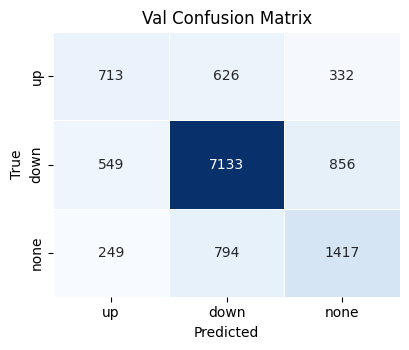

              precision    recall  f1-score   support

          up       0.47      0.43      0.45      1671
        down       0.83      0.84      0.83      8538
        none       0.54      0.58      0.56      2460

    accuracy                           0.73     12669
   macro avg       0.62      0.61      0.61     12669
weighted avg       0.73      0.73      0.73     12669



### Test confusion matrix (3x3, fixed order)

,up,down,none
up,563,708,580
down,425,7692,1022
none,184,690,805


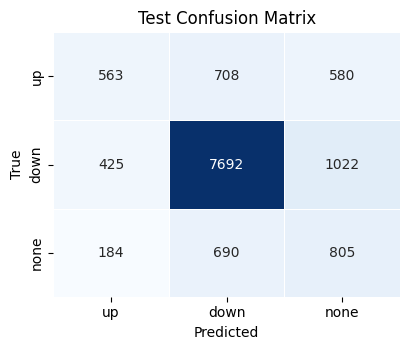

              precision    recall  f1-score   support

          up       0.48      0.30      0.37      1851
        down       0.85      0.84      0.84      9139
        none       0.33      0.48      0.39      1679

    accuracy                           0.72     12669
   macro avg       0.55      0.54      0.54     12669
weighted avg       0.72      0.72      0.72     12669



['val', 'test']

In [7]:
# Compute and display for available splits using reusable utils
available = get_available_prediction_splits(MODELS, splits=('val','test'))
for split in available:
    show_and_save_cm(MODELS, split)
if not available:
    print('No val/test predictions CSVs found in', MODELS)
available

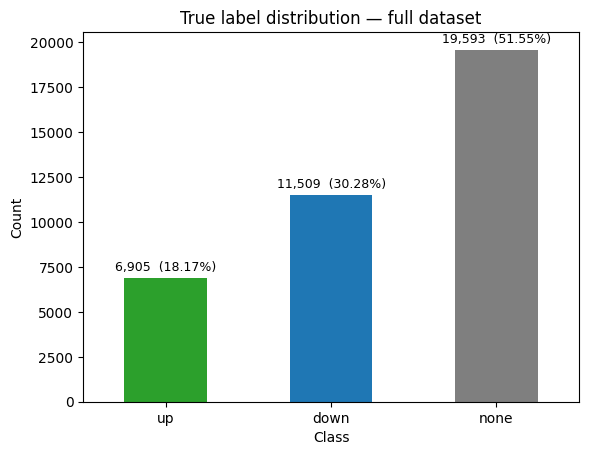

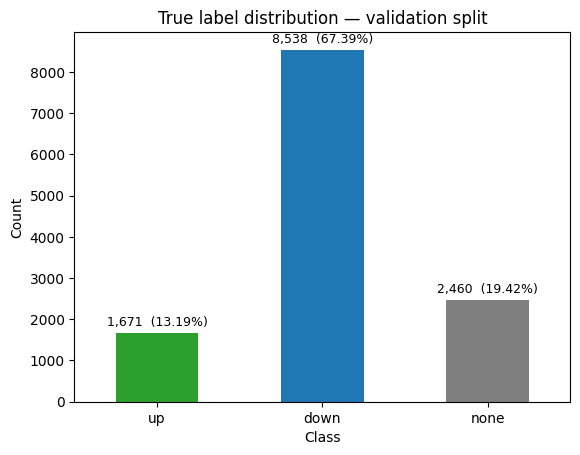

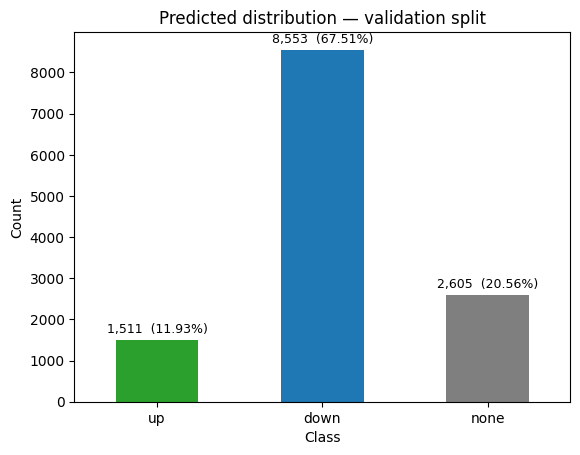

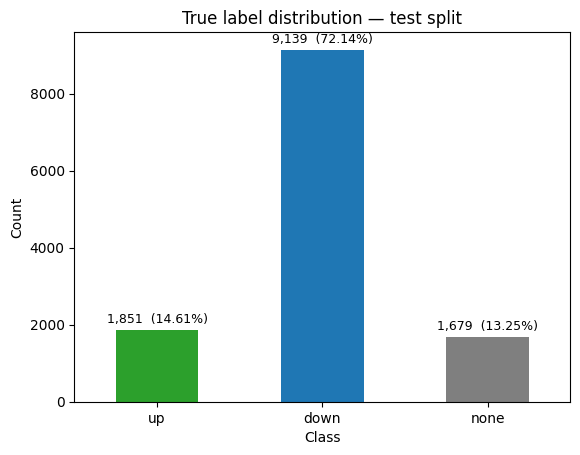

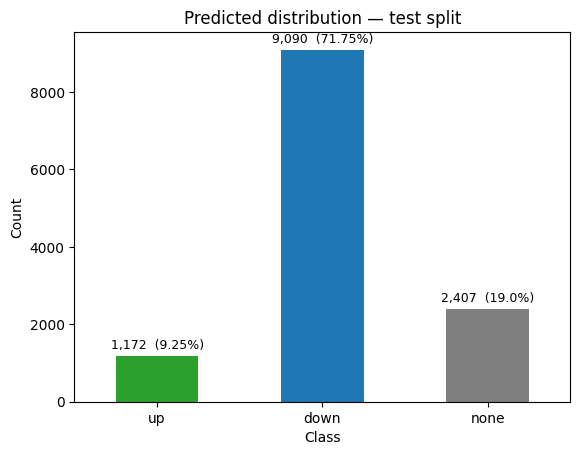

In [8]:
# Class distribution diagnostics: dataset, validation, and test
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Resolve project root relative to this notebook
nb_dir = Path.cwd()
ROOT = nb_dir.parent if nb_dir.name == 'notebooks' else nb_dir

model_dir = ROOT / 'models' / 'multiclass_ag'
reports_df_dir = ROOT / 'reports' / 'dataframes'

paths = {
    'dataset': reports_df_dir / 'multiclass_dataset.csv',
    'val': model_dir / 'val_predictions.csv',
    'test': model_dir / 'test_predictions.csv',
}

# Load available frames safely
frames = {}
for k, p in paths.items():
    if p.exists():
        frames[k] = pd.read_csv(p)

CLASSES = ['up', 'down', 'none']

def plot_distribution(df: pd.DataFrame, col: str, title: str):
    counts = df[col].astype(str).value_counts().reindex(CLASSES).fillna(0).astype(int)
    perc = (counts / counts.sum() * 100).round(2)
    ax = counts.plot(kind='bar', color=['#2ca02c', '#1f77b4', '#7f7f7f'])
    ax.set_title(title)
    ax.set_ylabel('Count')
    ax.set_xlabel('Class')
    ax.set_xticklabels(CLASSES, rotation=0)
    # Annotate with counts and percentages
    for i, v in enumerate(counts.values):
        ax.annotate(f'{v:,}  ({perc.iloc[i]}%)',
                    (i, v), xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom', fontsize=9)
    plt.show()

# 1) Overall dataset true label distribution (if snapshot exists)
if 'dataset' in frames:
    plot_distribution(frames['dataset'], 'RegClass+4', 'True label distribution — full dataset')

# 2) Validation split true/pred distribution (if available)
if 'val' in frames:
    plot_distribution(frames['val'], 'RegClass+4', 'True label distribution — validation split')
    plot_distribution(frames['val'], 'pred', 'Predicted distribution — validation split')

# 3) Test split true/pred distribution (if available)
if 'test' in frames:
    plot_distribution(frames['test'], 'RegClass+4', 'True label distribution — test split')
    plot_distribution(frames['test'], 'pred', 'Predicted distribution — test split')
